In [1]:
import os
import warnings

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import shap
from collections import defaultdict

In [3]:
cali_housing_path = '../data/California_Houses.csv'
RANDOM_SEED = 492

In [4]:
cali_df = pd.read_csv(cali_housing_path)

In [5]:
print(cali_df.head())

   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         558         219     37.85    -122.25        7768.086571   
4         565         259     37.85    -122.25        7768.086571   

   Distance_to_LA  Distance_to_SanDiego  Distance_to_SanJose  \
0   556529.158342         735501.806984         67432.5170

In [6]:
y_series = cali_df['Median_House_Value']
y = pd.DataFrame(y_series, columns=['Median_House_Value'])
features = [col for col in cali_df.columns if col != 'Median_House_Value']
X = cali_df[features]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [8]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [10]:
subset_indices = np.random.choice(X_train.index, size=len(X_train), replace=False)

X_train_subset = X_train.loc[subset_indices]
y_train_subset = y_train.loc[subset_indices]

print(X_train_scaled.head())

   Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  Population  Households  \
0      -0.220234    0.183029  -0.505330     -0.583271   -0.625333   -0.554684   
1       1.131720   -0.453352  -0.451797     -0.319166   -0.779725   -0.428479   
2       0.635054   -0.930638   0.592095      0.475528    1.118858    0.649526   
3       0.737734   -1.248828  -0.828835     -0.968722   -0.899710   -0.977998   
4      -0.158268   -1.169280  -0.095988     -0.114544   -0.374776   -0.381152   

   Latitude  Longitude  Distance_to_coast  Distance_to_LA  \
0  1.311518  -1.639785          -0.391522        1.490960   
1  1.054222  -1.455058          -0.700199        1.220967   
2  0.764180  -1.110565          -0.144717        0.850569   
3  0.591090  -1.050653          -0.568215        0.701779   
4  1.723191  -0.296764           2.921674        1.372870   

   Distance_to_SanDiego  Distance_to_SanJose  Distance_to_SanFrancisco  
0              1.449301            -0.918829                 -1.210694  


In [11]:
X_train_subset = X_train_subset.reset_index(drop=True)
y_train_subset = y_train_subset.reset_index(drop=True)

In [12]:
X_train_tensor = tf.constant(X_train_subset.values, dtype=tf.float32)
y_train_tensor = tf.constant(y_train_subset.values, dtype=tf.float32)
print(y_train_tensor.shape)

(16512, 1)


In [13]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, subportion = 0.8, sample_method = "RANDOM",verbose = 1): 
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subportion = subportion
        self.sample_method = sample_method
        self.verbose = verbose
        self.estimators = []
        self.lime_explainers = []
        self.shap_explainers = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=np.random.randint(self.n_trees//5, self.n_trees+1), # self.n_trees, #
            max_depth=self.max_depth, #np.random.randint(self.max_depth/2, self.max_depth+1), # self.max_depth, # 
            validation_ratio=0.1,
            subsample=self.subportion,
            sampling_method=self.sample_method,
            random_seed=self.seed, # try to set this first. Maybe this is enough
            verbose=1
        )
        return model
    
    # if not, the number of trees/depth different for each estimator

    def fit(self, X, y):
        
        X_tensor = tf.constant(X.values, dtype=tf.float32)
        y_tensor = tf.constant(y.values, dtype=tf.float32)
        tot_dataset_size = len(X)
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed)
            subset_size = int(self.subportion * tot_dataset_size)
            
            # Create a subset of the dataset using sampled indices
            subset_indices = np.random.choice(tot_dataset_size, size=subset_size, replace=False)
            X_subset = tf.gather(X_tensor, subset_indices)
            y_subset = tf.gather(y_tensor, subset_indices)
            
            # subset_dataset = (X_tensor, y_tensor)
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_subset,y_subset,verbose=0)
            self.estimators.append(estimator)
            
        # initiate explainers
        for model in self.estimators:
            lime_explainer = LimeTabularExplainer(X.values, feature_names=X.columns.tolist(), mode='regression')
            self.lime_explainers.append(lime_explainer)
            masker = shap.maskers.Independent(data = X_train.values)
            shap_explainer = shap.Explainer(model, masker=masker, feature_names=X.columns.tolist())
            self.shap_explainers.append(shap_explainer)
    
    #something's not right here
    def predict_mean(self, X):
        predictions = []
        
        for estimator in self.estimators:
            estimator_predictions = estimator.predict(X,verbose=0)  # Get predictions from the current estimator
            predictions.append(estimator_predictions)
        
        # Stack all predictions along the last axis (-1)
        predictions_stacked = tf.stack(predictions, axis=-1)
        
        # Compute mean and variance across the stacked predictions
        mean_prediction = tf.reduce_mean(predictions_stacked, axis=-1)
        sd_prediction = tf.math.reduce_std(predictions_stacked, axis=-1)
        
        return mean_prediction, sd_prediction
    
    def explain_lime(self, X):
        lime_explanations = []
        
        for estimator, explainer in zip(self.estimators, self.lime_explainers):
            for i in range(len(X)): 
                instance_explanation = explainer.explain_instance(X.iloc[i], estimator.predict, num_features=X.shape[1])
                lime_explanations.append(instance_explanation)
        return lime_explanations
    
    def explain_shap(self, X):
        shap_values = []
        
        for estimator, explainer in zip(self.estimators, self.shap_explainers):
            shap_value = explainer(X)
            shap_values.append(shap_value)
        
        return shap_values
    

In [14]:
gbt_model = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8, 
    sample_method='RANDOM',
    verbose=0
)

In [15]:
gbt_model_50 = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8,
    sample_method='RANDOM',
    verbose=0
)

In [16]:
gbt_model.fit(X_train_scaled, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpstx1z8f3 as temporary training directory


[WARNING 24-06-13 03:45:13.3808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:13.3815 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:13.3816 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-06-13 03:45:15.6614 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpstx1z8f3/model/ with prefix e48584854c454ffa
[INFO 24-06-13 03:45:15.6629 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-13 03:45:15.6629 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqeb8e2nq as temporary training directory


[WARNING 24-06-13 03:45:17.7469 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:17.7469 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:17.7469 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppbp_xbk4 as temporary training directory


[INFO 24-06-13 03:45:18.0943 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqeb8e2nq/model/ with prefix a255438083314ed9
[INFO 24-06-13 03:45:18.0957 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:18.1618 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:18.1619 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:18.1619 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf829jf1o as temporary training directory


[INFO 24-06-13 03:45:18.5743 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppbp_xbk4/model/ with prefix aaeb41e03d6c476c
[INFO 24-06-13 03:45:18.5756 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:18.6403 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:18.6403 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:18.6403 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_tezf5c as temporary training directory


[INFO 24-06-13 03:45:18.9676 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf829jf1o/model/ with prefix c3411e8f5393405a
[INFO 24-06-13 03:45:18.9689 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:19.0329 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:19.0329 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:19.0329 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0uivwlel as temporary training directory


[INFO 24-06-13 03:45:19.2125 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_tezf5c/model/ with prefix f34c3d5b844e41c3
[INFO 24-06-13 03:45:19.2130 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:19.2782 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:19.2782 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:19.2783 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpumtygtc4 as temporary training directory


[INFO 24-06-13 03:45:19.5373 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0uivwlel/model/ with prefix f276d62eae4b47da
[INFO 24-06-13 03:45:19.5382 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:19.6041 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:19.6041 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:19.6041 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppckl1pv6 as temporary training directory


[INFO 24-06-13 03:45:19.9876 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpumtygtc4/model/ with prefix ddd498612796416b
[INFO 24-06-13 03:45:19.9893 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:20.0546 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:20.0546 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:20.0547 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0xm96yyv as temporary training directory


[INFO 24-06-13 03:45:20.4475 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppckl1pv6/model/ with prefix b3cc2cf53bc94efe
[INFO 24-06-13 03:45:20.4491 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:20.5131 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:20.5132 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:20.5132 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyi8369m3 as temporary training directory


[INFO 24-06-13 03:45:20.7097 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0xm96yyv/model/ with prefix 3e9d66a859994735
[INFO 24-06-13 03:45:20.7104 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:20.7765 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:20.7765 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:20.7765 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp82xnsl7j as temporary training directory


[INFO 24-06-13 03:45:21.1726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyi8369m3/model/ with prefix ec15880829cc4ccf
[INFO 24-06-13 03:45:21.1743 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:21.2397 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:21.2397 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:21.2397 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcc4v4cil as temporary training directory


[INFO 24-06-13 03:45:21.5642 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp82xnsl7j/model/ with prefix e8231c74ee704ffa
[INFO 24-06-13 03:45:21.5655 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:21.6292 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:21.6292 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:21.6292 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnkuey_om as temporary training directory


[INFO 24-06-13 03:45:21.8346 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcc4v4cil/model/ with prefix a05f5da6cc8345e5
[INFO 24-06-13 03:45:21.8352 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:21.9017 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:21.9017 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:21.9017 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50pkyk_x as temporary training directory


[INFO 24-06-13 03:45:22.0817 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnkuey_om/model/ with prefix 0881baf985954ec9
[INFO 24-06-13 03:45:22.0822 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:22.1487 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:22.1488 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:22.1488 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwywfsjvt as temporary training directory


[INFO 24-06-13 03:45:22.4076 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50pkyk_x/model/ with prefix 4680bf3605db4e33
[INFO 24-06-13 03:45:22.4085 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:22.4762 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:22.4762 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:22.4762 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4y777h4y as temporary training directory


[INFO 24-06-13 03:45:22.7716 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwywfsjvt/model/ with prefix 18bcfcac35d54be2
[INFO 24-06-13 03:45:22.7728 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:22.8388 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:22.8388 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:22.8388 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8mmo4xsm as temporary training directory


[INFO 24-06-13 03:45:23.1906 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4y777h4y/model/ with prefix b775bd308f124d69
[INFO 24-06-13 03:45:23.1921 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:23.2596 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:23.2596 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:23.2596 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu7muvjkl as temporary training directory


[INFO 24-06-13 03:45:23.4888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8mmo4xsm/model/ with prefix db3a2320990b4103
[INFO 24-06-13 03:45:23.4896 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:23.5559 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:23.5559 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:23.5560 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5i5c0qfn as temporary training directory


[INFO 24-06-13 03:45:23.8432 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu7muvjkl/model/ with prefix 2ffc0b1d826a432c
[INFO 24-06-13 03:45:23.8443 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:23.9101 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:23.9101 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:23.9101 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1zfhetvt as temporary training directory


[INFO 24-06-13 03:45:24.2354 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5i5c0qfn/model/ with prefix 1b665984988a4c25
[INFO 24-06-13 03:45:24.2368 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:24.3029 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:24.3029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:24.3029 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd7l0x2gp as temporary training directory


[INFO 24-06-13 03:45:24.6876 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1zfhetvt/model/ with prefix 34c4a71b6ffe489a
[INFO 24-06-13 03:45:24.6893 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:24.7566 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:24.7566 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:24.7566 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpros8z1a5 as temporary training directory


[INFO 24-06-13 03:45:24.9435 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd7l0x2gp/model/ with prefix 01a99bbcd7d94d5d
[INFO 24-06-13 03:45:24.9440 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:25.0080 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:25.0080 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:25.0080 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphv2sz0hc as temporary training directory


[INFO 24-06-13 03:45:25.3127 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpros8z1a5/model/ with prefix 00eb65a631c14b84
[INFO 24-06-13 03:45:25.3138 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:25.3790 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:25.3790 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:25.3790 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx94xd889 as temporary training directory


[INFO 24-06-13 03:45:25.6828 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphv2sz0hc/model/ with prefix 16eb3428dd764f50
[INFO 24-06-13 03:45:25.6840 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-13 03:45:25.6840 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:25.7500 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:25.7501 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:25.7501 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt0rc8q6q as temporary training directory


[INFO 24-06-13 03:45:25.9761 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx94xd889/model/ with prefix 830dd76a29a94edd
[INFO 24-06-13 03:45:25.9768 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:26.1522 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:26.1523 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:26.1523 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkmom84t2 as temporary training directory


[INFO 24-06-13 03:45:26.4857 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt0rc8q6q/model/ with prefix 5d0e04a356904c89
[INFO 24-06-13 03:45:26.4871 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:26.5538 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:26.5538 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:26.5538 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0lkistpd as temporary training directory


[INFO 24-06-13 03:45:26.9099 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkmom84t2/model/ with prefix 2e7b9c5de058448b
[INFO 24-06-13 03:45:26.9114 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:26.9780 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:26.9780 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:26.9780 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpauljtxae as temporary training directory


[INFO 24-06-13 03:45:27.2811 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0lkistpd/model/ with prefix cc10cb2689f74e60
[INFO 24-06-13 03:45:27.2823 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:27.3482 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:27.3482 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:27.3482 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1fmn076 as temporary training directory


[INFO 24-06-13 03:45:27.5730 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpauljtxae/model/ with prefix c95ada9aa9a84af4
[INFO 24-06-13 03:45:27.5737 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:27.6396 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:27.6396 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:27.6397 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1wsl5a57 as temporary training directory


[INFO 24-06-13 03:45:27.8587 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1fmn076/model/ with prefix 9139f56c616b4b14
[INFO 24-06-13 03:45:27.8594 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:27.9261 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:27.9262 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:27.9262 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6st8ums_ as temporary training directory


[INFO 24-06-13 03:45:28.1730 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1wsl5a57/model/ with prefix 76ffb10c6d81468a
[INFO 24-06-13 03:45:28.1739 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:28.2387 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:28.2387 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:28.2388 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxv56nfi as temporary training directory


[INFO 24-06-13 03:45:28.5317 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6st8ums_/model/ with prefix 92a0740d98904cb0
[INFO 24-06-13 03:45:28.5329 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:28.5966 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:28.5966 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:28.5967 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptph1d__x as temporary training directory


[INFO 24-06-13 03:45:28.9895 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxv56nfi/model/ with prefix a7a0927b0db34e28
[INFO 24-06-13 03:45:28.9912 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:29.0561 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:29.0562 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:29.0562 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5rw_smbq as temporary training directory


[INFO 24-06-13 03:45:29.3036 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptph1d__x/model/ with prefix 48ec9f59ba164398
[INFO 24-06-13 03:45:29.3045 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:29.3704 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:29.3704 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:29.3704 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcrv4u_6d as temporary training directory


[INFO 24-06-13 03:45:29.7309 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5rw_smbq/model/ with prefix c42840c85be64fb8
[INFO 24-06-13 03:45:29.7324 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:29.7997 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:29.7997 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:29.7997 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx1vbcs8o as temporary training directory


[INFO 24-06-13 03:45:30.0824 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcrv4u_6d/model/ with prefix 88d637f0d41341b0
[INFO 24-06-13 03:45:30.0835 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:30.1499 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:30.1500 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:30.1500 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwhvmh0v3 as temporary training directory


[INFO 24-06-13 03:45:30.5282 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx1vbcs8o/model/ with prefix 3edc01f0e749425c
[INFO 24-06-13 03:45:30.5298 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:30.5942 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:30.5942 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:30.5942 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2df4yrwc as temporary training directory


[INFO 24-06-13 03:45:30.8545 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwhvmh0v3/model/ with prefix 6021aef773df45db
[INFO 24-06-13 03:45:30.8555 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:30.9218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:30.9218 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:30.9218 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qq9ddj0 as temporary training directory


[INFO 24-06-13 03:45:31.1249 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2df4yrwc/model/ with prefix 20cbfbf4db174e67
[INFO 24-06-13 03:45:31.1255 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:31.1932 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:31.1932 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:31.1932 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxpcvoi9j as temporary training directory


[INFO 24-06-13 03:45:31.4146 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qq9ddj0/model/ with prefix dc7d0e7c2152431b
[INFO 24-06-13 03:45:31.4154 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:31.4808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:31.4808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:31.4808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnafqf6ws as temporary training directory


[INFO 24-06-13 03:45:31.6781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxpcvoi9j/model/ with prefix 15cb5b7bba774001
[INFO 24-06-13 03:45:31.6787 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:31.7451 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:31.7451 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:31.7451 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpms9cssw_ as temporary training directory


[INFO 24-06-13 03:45:31.9484 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnafqf6ws/model/ with prefix 74cc7e3f65734a5e
[INFO 24-06-13 03:45:31.9490 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:32.0148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:32.0148 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:32.0148 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpghy9e8s0 as temporary training directory


[INFO 24-06-13 03:45:32.3961 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpms9cssw_/model/ with prefix 69c7c9ef4ec64578
[INFO 24-06-13 03:45:32.3978 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:32.4648 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:32.4648 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:32.4648 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmzeixj26 as temporary training directory


[INFO 24-06-13 03:45:32.6678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpghy9e8s0/model/ with prefix 56f052a96afc419d
[INFO 24-06-13 03:45:32.6685 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:32.7342 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:32.7342 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:32.7342 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpswon3sso as temporary training directory


[INFO 24-06-13 03:45:33.0094 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmzeixj26/model/ with prefix f27d9053419242b7
[INFO 24-06-13 03:45:33.0104 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:33.0757 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:33.0757 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:33.0757 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpy9fw8v as temporary training directory


[INFO 24-06-13 03:45:33.3008 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpswon3sso/model/ with prefix d4e2c96f6d4942f8
[INFO 24-06-13 03:45:33.3015 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:33.3685 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:33.3685 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:33.3686 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp07058zwx as temporary training directory


[INFO 24-06-13 03:45:33.5988 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpy9fw8v/model/ with prefix 090ff391684842be
[INFO 24-06-13 03:45:33.5996 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:33.6663 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:33.6663 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:33.6663 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphul6jvyn as temporary training directory


[INFO 24-06-13 03:45:33.9184 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp07058zwx/model/ with prefix 2e1a05eec65f4655
[INFO 24-06-13 03:45:33.9193 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:33.9851 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:33.9851 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:33.9851 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgunyfc8t as temporary training directory


[INFO 24-06-13 03:45:34.1678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphul6jvyn/model/ with prefix 8c6742813fa04828
[INFO 24-06-13 03:45:34.1683 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:34.2347 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:34.2347 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:34.2347 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8x6o7qv7 as temporary training directory


[INFO 24-06-13 03:45:34.7343 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgunyfc8t/model/ with prefix b24135b565f747fa
[INFO 24-06-13 03:45:34.7359 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:34.8046 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:34.8046 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:34.8046 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1294k67t as temporary training directory


[INFO 24-06-13 03:45:35.1338 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8x6o7qv7/model/ with prefix bafdcaf33f224781
[INFO 24-06-13 03:45:35.1352 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:35.2010 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:35.2010 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:35.2010 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpemzv1k3w as temporary training directory


[INFO 24-06-13 03:45:35.4998 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1294k67t/model/ with prefix 6e1ede04acff4f95
[INFO 24-06-13 03:45:35.5010 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:35.5658 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:35.5658 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:35.5658 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv3o7ya3v as temporary training directory


[INFO 24-06-13 03:45:35.8126 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpemzv1k3w/model/ with prefix 41970203fad5424e
[INFO 24-06-13 03:45:35.8134 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-13 03:45:35.8134 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:35.8790 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:35.8790 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:35.8791 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqlmyb1bl as temporary training directory


[INFO 24-06-13 03:45:36.2147 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv3o7ya3v/model/ with prefix 0a7a938c80784c70
[INFO 24-06-13 03:45:36.2161 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:36.2840 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:36.2840 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:36.2840 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxr05p28z as temporary training directory


[INFO 24-06-13 03:45:36.6721 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqlmyb1bl/model/ with prefix 08a3bd51eb494e30
[INFO 24-06-13 03:45:36.6737 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:36.7409 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:36.7409 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:36.7409 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9eo5wgt3 as temporary training directory


[INFO 24-06-13 03:45:37.0470 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxr05p28z/model/ with prefix 8111c03763bc458a
[INFO 24-06-13 03:45:37.0482 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:37.1122 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:37.1122 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:37.1122 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprrx6b0l9 as temporary training directory


[INFO 24-06-13 03:45:37.3985 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9eo5wgt3/model/ with prefix c2faf4fa33ec4076
[INFO 24-06-13 03:45:37.3996 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:37.4653 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:37.4653 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:37.4653 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy68gk600 as temporary training directory


[INFO 24-06-13 03:45:37.6880 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprrx6b0l9/model/ with prefix ad7501b7bc214fc2
[INFO 24-06-13 03:45:37.6888 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:37.7551 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:37.7551 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:37.7551 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_msopr00 as temporary training directory


[INFO 24-06-13 03:45:37.9769 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy68gk600/model/ with prefix 92de260f39474a78
[INFO 24-06-13 03:45:37.9776 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:38.0432 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:38.0432 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:38.0432 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7qombenv as temporary training directory


[INFO 24-06-13 03:45:38.3816 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_msopr00/model/ with prefix d8cc4aab51484bb9
[INFO 24-06-13 03:45:38.3830 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:38.4485 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:38.4486 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:38.4486 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9o6p58h4 as temporary training directory


[INFO 24-06-13 03:45:38.7345 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7qombenv/model/ with prefix 73b2b049415947ed
[INFO 24-06-13 03:45:38.7356 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:38.8054 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:38.8054 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:38.8054 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0mbkvfpw as temporary training directory


[INFO 24-06-13 03:45:39.1838 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9o6p58h4/model/ with prefix 69061dbeb5d54f13
[INFO 24-06-13 03:45:39.1854 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:39.2533 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:39.2534 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:39.2534 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprukzarpc as temporary training directory


[INFO 24-06-13 03:45:39.5558 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0mbkvfpw/model/ with prefix e7199dbc02b0409f
[INFO 24-06-13 03:45:39.5570 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:39.6231 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:39.6231 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:39.6231 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pi40xtw as temporary training directory


[INFO 24-06-13 03:45:39.8698 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprukzarpc/model/ with prefix cb4c7da173b8443f
[INFO 24-06-13 03:45:39.8706 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:39.9367 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:39.9368 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:39.9368 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8cjeu6ak as temporary training directory


[INFO 24-06-13 03:45:40.3355 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pi40xtw/model/ with prefix d4cf33bb0b2e4b1f
[INFO 24-06-13 03:45:40.3372 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:40.4045 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:40.4045 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:40.4045 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeama08vp as temporary training directory


[INFO 24-06-13 03:45:40.6632 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8cjeu6ak/model/ with prefix 2455650afd494743
[INFO 24-06-13 03:45:40.6641 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:40.7316 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:40.7316 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:40.7316 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmput64wq5p as temporary training directory


[INFO 24-06-13 03:45:41.0266 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeama08vp/model/ with prefix 0d9c1ea9209749bf
[INFO 24-06-13 03:45:41.0277 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:41.0969 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:41.0970 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:41.0970 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp72f5gjtd as temporary training directory


[INFO 24-06-13 03:45:41.3003 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmput64wq5p/model/ with prefix 99a528bbfdd34e57
[INFO 24-06-13 03:45:41.3009 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:41.3678 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:41.3678 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:41.3678 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmz86jumj as temporary training directory


[INFO 24-06-13 03:45:41.7017 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp72f5gjtd/model/ with prefix 8c2487c6f68a4244
[INFO 24-06-13 03:45:41.7031 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:41.7710 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:41.7710 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:41.7710 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsz6pzgjx as temporary training directory


[INFO 24-06-13 03:45:41.9650 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmz86jumj/model/ with prefix cfd2d18e1a244950
[INFO 24-06-13 03:45:41.9655 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:42.0321 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:42.0322 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:42.0322 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6jq93x9 as temporary training directory


[INFO 24-06-13 03:45:42.3362 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsz6pzgjx/model/ with prefix 72f4b37d802547a9
[INFO 24-06-13 03:45:42.3373 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:42.4054 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:42.4055 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:42.4055 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxf_5maj2 as temporary training directory


[INFO 24-06-13 03:45:42.7419 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6jq93x9/model/ with prefix acd5af2da66b486f
[INFO 24-06-13 03:45:42.7433 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:42.8124 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:42.8124 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:42.8124 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_x7oazcs as temporary training directory


[INFO 24-06-13 03:45:43.0457 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxf_5maj2/model/ with prefix 3e16e2b810774a3d
[INFO 24-06-13 03:45:43.0464 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:43.1139 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:43.1139 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:43.1139 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsdfdbhi2 as temporary training directory


[INFO 24-06-13 03:45:43.3236 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_x7oazcs/model/ with prefix 8343e6e10e3e4453
[INFO 24-06-13 03:45:43.3242 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:43.3908 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:43.3908 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:43.3908 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyrx37cls as temporary training directory


[INFO 24-06-13 03:45:43.6944 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsdfdbhi2/model/ with prefix 3fa011fe59344542
[INFO 24-06-13 03:45:43.6956 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:43.7637 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:43.7637 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:43.7637 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwyiy12aq as temporary training directory


[INFO 24-06-13 03:45:44.0046 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyrx37cls/model/ with prefix c7e2c76a90534f0a
[INFO 24-06-13 03:45:44.0055 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:44.0723 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:44.0723 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:44.0723 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptit5b0p7 as temporary training directory


[INFO 24-06-13 03:45:44.2986 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwyiy12aq/model/ with prefix 8759c0e73ffa4aec
[INFO 24-06-13 03:45:44.2993 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:44.3645 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:44.3645 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:44.3646 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58ehe2r_ as temporary training directory


[INFO 24-06-13 03:45:44.5931 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptit5b0p7/model/ with prefix e8e2485aeff9494b
[INFO 24-06-13 03:45:44.5939 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:44.6618 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:44.6618 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:44.6618 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiz95ocmn as temporary training directory


[INFO 24-06-13 03:45:44.8916 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58ehe2r_/model/ with prefix f1295d59d481490d
[INFO 24-06-13 03:45:44.8923 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:44.9600 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:44.9600 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:44.9600 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm3ihmwor as temporary training directory


[INFO 24-06-13 03:45:45.2264 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiz95ocmn/model/ with prefix f72bcae913934b55
[INFO 24-06-13 03:45:45.2274 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:45:45.2967 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:45.2967 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:45:45.2967 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-06-13 03:45:45.8687 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm3ihmwor/model/ with prefix f8279759a49a41d3
[INFO 24-06-13 03:45:45.8704 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-13 03:45:45.8704 CEST kernel.cc:1061] Use fast ge

In [17]:
X_train_subset, _, y_train_subset, _ = train_test_split(X_train_scaled, y_train, test_size=0.5, random_state=RANDOM_SEED)
gbt_model_50.fit(X_train_subset, y_train_subset)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp37qlzihq as temporary training directory


[WARNING 24-06-13 03:46:06.0401 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:06.0401 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:06.0401 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp83pe35dx as temporary training directory


[INFO 24-06-13 03:46:06.2475 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp37qlzihq/model/ with prefix 549cb90f50a54415
[INFO 24-06-13 03:46:06.2483 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-13 03:46:06.2483 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:06.3240 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:06.3240 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:06.3240 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr088kg03 as temporary training directory


[INFO 24-06-13 03:46:06.5734 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp83pe35dx/model/ with prefix c27763f3f062410d
[INFO 24-06-13 03:46:06.5745 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:06.6452 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:06.6453 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:06.6453 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbo1h2aj0 as temporary training directory


[INFO 24-06-13 03:46:06.9774 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr088kg03/model/ with prefix 57cfe823da9e4503
[INFO 24-06-13 03:46:06.9791 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:07.0456 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:07.0456 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:07.0457 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_qcm9qhs as temporary training directory


[INFO 24-06-13 03:46:07.3132 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbo1h2aj0/model/ with prefix 9053758da5304350
[INFO 24-06-13 03:46:07.3146 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:07.3857 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:07.3857 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:07.3857 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmy18htli as temporary training directory


[INFO 24-06-13 03:46:07.6781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_qcm9qhs/model/ with prefix 29378e0475484098
[INFO 24-06-13 03:46:07.6796 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:07.7450 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:07.7450 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:07.7450 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp715tf_a6 as temporary training directory


[INFO 24-06-13 03:46:07.9639 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmy18htli/model/ with prefix b60285727be7438d
[INFO 24-06-13 03:46:07.9650 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:08.0302 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:08.0302 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:08.0303 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoimk39jo as temporary training directory


[INFO 24-06-13 03:46:08.2253 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp715tf_a6/model/ with prefix a8447a871f984dd2
[INFO 24-06-13 03:46:08.2263 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:08.2917 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:08.2918 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:08.2918 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpny68so_o as temporary training directory


[INFO 24-06-13 03:46:08.5514 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoimk39jo/model/ with prefix c77053a272ca4d1b
[INFO 24-06-13 03:46:08.5528 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:08.6191 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:08.6191 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:08.6191 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf8ozzp_0 as temporary training directory


[INFO 24-06-13 03:46:08.8474 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpny68so_o/model/ with prefix 556945498be44549
[INFO 24-06-13 03:46:08.8486 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:08.9143 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:08.9143 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:08.9143 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj56emdk7 as temporary training directory


[INFO 24-06-13 03:46:09.1748 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf8ozzp_0/model/ with prefix bf042f5451d74aec
[INFO 24-06-13 03:46:09.1763 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:09.2418 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:09.2418 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:09.2418 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4kmqbyz as temporary training directory


[INFO 24-06-13 03:46:09.4452 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj56emdk7/model/ with prefix 8e84188a986149cd
[INFO 24-06-13 03:46:09.4461 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:09.5113 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:09.5113 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:09.5113 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzyhghf9v as temporary training directory


[INFO 24-06-13 03:46:09.7276 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4kmqbyz/model/ with prefix 08584150db9844ef
[INFO 24-06-13 03:46:09.7288 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:09.7945 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:09.7946 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:09.7946 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnfrsufps as temporary training directory


[INFO 24-06-13 03:46:09.9681 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzyhghf9v/model/ with prefix 30291b898e974231
[INFO 24-06-13 03:46:09.9688 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:10.0355 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:10.0355 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:10.0355 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe82gfcfg as temporary training directory


[INFO 24-06-13 03:46:10.2849 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnfrsufps/model/ with prefix eec8dc7fb1474f8e
[INFO 24-06-13 03:46:10.2863 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:10.3548 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:10.3548 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:10.3548 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpho713jku as temporary training directory


[INFO 24-06-13 03:46:10.6030 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe82gfcfg/model/ with prefix e2e20f1121af4dc1
[INFO 24-06-13 03:46:10.6043 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:10.6694 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:10.6695 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:10.6695 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7t86pg4w as temporary training directory


[INFO 24-06-13 03:46:10.8749 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpho713jku/model/ with prefix b0c838fb3a024495
[INFO 24-06-13 03:46:10.8759 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:10.9410 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:10.9410 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:10.9410 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwa79kg0y as temporary training directory


[INFO 24-06-13 03:46:11.1455 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7t86pg4w/model/ with prefix 95cc41fb0ce34c1a
[INFO 24-06-13 03:46:11.1465 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:11.2115 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:11.2115 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:11.2115 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy9pdg_jd as temporary training directory


[INFO 24-06-13 03:46:11.3705 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwa79kg0y/model/ with prefix 3071bb79a21649dd
[INFO 24-06-13 03:46:11.3710 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:11.4374 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:11.4374 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:11.4374 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfglcwzeq as temporary training directory


[INFO 24-06-13 03:46:11.6125 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy9pdg_jd/model/ with prefix bef3ea86ed0843b0
[INFO 24-06-13 03:46:11.6132 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:11.6781 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:11.6781 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:11.6781 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkewgarom as temporary training directory


[INFO 24-06-13 03:46:11.9445 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfglcwzeq/model/ with prefix 29767af6bc0f451f
[INFO 24-06-13 03:46:11.9460 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:12.0136 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:12.0136 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:12.0136 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7n__wqhe as temporary training directory


[INFO 24-06-13 03:46:12.2991 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkewgarom/model/ with prefix 73fc1e3995c54f1e
[INFO 24-06-13 03:46:12.3008 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:12.3701 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:12.3701 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:12.3701 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfv54_fuo as temporary training directory


[INFO 24-06-13 03:46:12.6303 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7n__wqhe/model/ with prefix 5696ce7dc1034d57
[INFO 24-06-13 03:46:12.6318 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:12.6979 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:12.6979 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:12.6979 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzr2kg2r3 as temporary training directory


[INFO 24-06-13 03:46:12.9154 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfv54_fuo/model/ with prefix cc199a7ea7434825
[INFO 24-06-13 03:46:12.9164 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:12.9816 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:12.9816 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:12.9816 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph4bxrd40 as temporary training directory


[INFO 24-06-13 03:46:13.2187 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzr2kg2r3/model/ with prefix 057ec7c8ba724656
[INFO 24-06-13 03:46:13.2199 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:13.2859 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:13.2860 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:13.2860 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwtrkguoq as temporary training directory


[INFO 24-06-13 03:46:13.5453 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph4bxrd40/model/ with prefix 17a007f518254abb
[INFO 24-06-13 03:46:13.5467 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:13.6140 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:13.6141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:13.6141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptmiscwhp as temporary training directory


[INFO 24-06-13 03:46:13.8083 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwtrkguoq/model/ with prefix 994424dc094340b1
[INFO 24-06-13 03:46:13.8092 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:13.8779 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:13.8780 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:13.8780 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprsvn68im as temporary training directory


[INFO 24-06-13 03:46:14.0996 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptmiscwhp/model/ with prefix 0d21ded1ad864d08
[INFO 24-06-13 03:46:14.1007 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:14.1658 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:14.1659 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:14.1659 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_uykjha1 as temporary training directory


[INFO 24-06-13 03:46:14.3513 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprsvn68im/model/ with prefix 46f2ca57c6244379
[INFO 24-06-13 03:46:14.3520 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:14.4212 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:14.4212 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:14.4212 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppi18z2ln as temporary training directory


[INFO 24-06-13 03:46:14.5774 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_uykjha1/model/ with prefix ae793503cba740ba
[INFO 24-06-13 03:46:14.5779 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:14.6460 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:14.6460 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:14.6460 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpea0uxbta as temporary training directory


[INFO 24-06-13 03:46:14.8273 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppi18z2ln/model/ with prefix 80ea2809ae8d4bad
[INFO 24-06-13 03:46:14.8281 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:14.8989 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:14.8989 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:14.8989 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprsts90xt as temporary training directory


[INFO 24-06-13 03:46:15.2803 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpea0uxbta/model/ with prefix 13151dc8187b4bc8
[INFO 24-06-13 03:46:15.2809 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:15.3506 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:15.3506 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:15.3507 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpje_0g4kx as temporary training directory


[INFO 24-06-13 03:46:15.5615 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprsts90xt/model/ with prefix cc573ebfb4134b36
[INFO 24-06-13 03:46:15.5625 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:15.6285 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:15.6285 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:15.6285 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsznaqpog as temporary training directory


[INFO 24-06-13 03:46:15.8401 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpje_0g4kx/model/ with prefix 6b4aedfc0e5f4d1d
[INFO 24-06-13 03:46:15.8411 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:15.9091 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:15.9091 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:15.9091 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp82xdszgw as temporary training directory


[INFO 24-06-13 03:46:16.1559 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsznaqpog/model/ with prefix 3d997e05faef4813
[INFO 24-06-13 03:46:16.1573 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:16.2230 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:16.2230 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:16.2231 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp73y6d9c7 as temporary training directory


[INFO 24-06-13 03:46:16.4915 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp82xdszgw/model/ with prefix 213d6c52bfb047ae
[INFO 24-06-13 03:46:16.4929 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-13 03:46:16.4930 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:16.5586 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:16.5587 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:16.5587 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7jabunmm as temporary training directory


[INFO 24-06-13 03:46:16.7982 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp73y6d9c7/model/ with prefix eba06f5e0a2f4710
[INFO 24-06-13 03:46:16.7995 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:16.8694 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:16.8695 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:16.8695 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi61ti9ad as temporary training directory


[INFO 24-06-13 03:46:17.0252 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7jabunmm/model/ with prefix ea4488bb017c40a3
[INFO 24-06-13 03:46:17.0257 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:17.0943 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:17.0943 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:17.0943 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3mjjcaqs as temporary training directory


[INFO 24-06-13 03:46:17.3784 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi61ti9ad/model/ with prefix 93675012b0e64b06
[INFO 24-06-13 03:46:17.3800 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:17.4463 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:17.4463 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:17.4463 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf56ionb0 as temporary training directory


[INFO 24-06-13 03:46:17.7283 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3mjjcaqs/model/ with prefix 8110743a556d4bf5
[INFO 24-06-13 03:46:17.7299 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:17.7956 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:17.7956 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:17.7956 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp807y48nv as temporary training directory


[INFO 24-06-13 03:46:18.0771 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf56ionb0/model/ with prefix 3248c448b9e34a70
[INFO 24-06-13 03:46:18.0787 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:18.1453 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:18.1453 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:18.1453 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_yfx368v as temporary training directory


[INFO 24-06-13 03:46:18.3929 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp807y48nv/model/ with prefix 433d46e2cc8c4896
[INFO 24-06-13 03:46:18.3942 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:18.4604 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:18.4604 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:18.4605 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfgqe0ly4 as temporary training directory


[INFO 24-06-13 03:46:18.6138 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_yfx368v/model/ with prefix 6e44d1dfb4924685
[INFO 24-06-13 03:46:18.6143 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:18.6816 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:18.6816 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:18.6816 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkruwomew as temporary training directory


[INFO 24-06-13 03:46:18.9551 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfgqe0ly4/model/ with prefix 6f203e7df23f48ea
[INFO 24-06-13 03:46:18.9567 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:19.0242 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:19.0242 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:19.0242 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfzwojgea as temporary training directory


[INFO 24-06-13 03:46:19.2312 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkruwomew/model/ with prefix 29655b6d547248df
[INFO 24-06-13 03:46:19.2321 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:19.2984 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:19.2985 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:19.2985 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprz2w5abm as temporary training directory


[INFO 24-06-13 03:46:19.4691 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfzwojgea/model/ with prefix dab367880bf74e32
[INFO 24-06-13 03:46:19.4697 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:19.5357 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:19.5358 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:19.5358 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbzuyt2_b as temporary training directory


[INFO 24-06-13 03:46:19.7604 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprz2w5abm/model/ with prefix 26eeb997c85f40b0
[INFO 24-06-13 03:46:19.7616 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:19.8281 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:19.8281 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:19.8281 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo1rknn5j as temporary training directory


[INFO 24-06-13 03:46:20.0062 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbzuyt2_b/model/ with prefix 53074a7206484d78
[INFO 24-06-13 03:46:20.0070 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:20.0735 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:20.0735 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:20.0736 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpivnzg76f as temporary training directory


[INFO 24-06-13 03:46:20.3428 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo1rknn5j/model/ with prefix a58b1421d7104763
[INFO 24-06-13 03:46:20.3443 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:20.4139 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:20.4139 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:20.4139 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxvw8etzj as temporary training directory


[INFO 24-06-13 03:46:20.6337 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpivnzg76f/model/ with prefix f4da68f72dad4e43
[INFO 24-06-13 03:46:20.6348 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:20.7012 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:20.7012 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:20.7012 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0s_i93qt as temporary training directory


[INFO 24-06-13 03:46:20.9318 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxvw8etzj/model/ with prefix 71234882fdab466d
[INFO 24-06-13 03:46:20.9329 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:21.0000 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:21.0000 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:21.0001 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1t5zq7l_ as temporary training directory


[INFO 24-06-13 03:46:21.2115 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0s_i93qt/model/ with prefix 34b1934126204ea9
[INFO 24-06-13 03:46:21.2125 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:21.2785 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:21.2786 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:21.2786 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ytbz_im as temporary training directory


[INFO 24-06-13 03:46:21.4532 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1t5zq7l_/model/ with prefix 8bf7695199924895
[INFO 24-06-13 03:46:21.4538 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:21.5206 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:21.5206 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:21.5206 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplymr4qn0 as temporary training directory


[INFO 24-06-13 03:46:21.7189 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ytbz_im/model/ with prefix 6b2b55ec5131432c
[INFO 24-06-13 03:46:21.7197 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:21.7864 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:21.7864 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:21.7864 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvc7esgbi as temporary training directory


[INFO 24-06-13 03:46:21.9988 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplymr4qn0/model/ with prefix 44566f91a278444c
[INFO 24-06-13 03:46:21.9998 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:22.0663 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:22.0663 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:22.0663 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqhfclg_d as temporary training directory


[INFO 24-06-13 03:46:22.3317 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvc7esgbi/model/ with prefix 8bd5547272d445e6
[INFO 24-06-13 03:46:22.3331 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:22.4041 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:22.4041 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:22.4042 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbn1wt3ka as temporary training directory


[INFO 24-06-13 03:46:22.6143 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqhfclg_d/model/ with prefix cdcd402cc0be48f0
[INFO 24-06-13 03:46:22.6153 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:22.6808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:22.6808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:22.6808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpovjst6hb as temporary training directory


[INFO 24-06-13 03:46:22.8340 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbn1wt3ka/model/ with prefix b9eb8cccc0aa48ca
[INFO 24-06-13 03:46:22.8345 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:22.9048 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:22.9049 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:22.9049 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi6f17h5e as temporary training directory


[INFO 24-06-13 03:46:23.1283 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpovjst6hb/model/ with prefix 6c2a8fe18b054b48
[INFO 24-06-13 03:46:23.1294 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:23.1973 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:23.1973 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:23.1973 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyj1dwe7v as temporary training directory


[INFO 24-06-13 03:46:23.3872 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi6f17h5e/model/ with prefix a082568f92d64f23
[INFO 24-06-13 03:46:23.3879 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:23.4574 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:23.4574 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:23.4574 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphttbmxeu as temporary training directory


[INFO 24-06-13 03:46:23.7061 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyj1dwe7v/model/ with prefix b0fb51a698e44e8c
[INFO 24-06-13 03:46:23.7074 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:23.7749 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:23.7750 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:23.7750 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp59qgmjxc as temporary training directory


[INFO 24-06-13 03:46:24.0381 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphttbmxeu/model/ with prefix 492af4b159864092
[INFO 24-06-13 03:46:24.0396 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:24.1066 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:24.1066 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:24.1066 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps5ed5lwo as temporary training directory


[INFO 24-06-13 03:46:24.3158 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp59qgmjxc/model/ with prefix 025834e29ec7482e
[INFO 24-06-13 03:46:24.3168 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:24.3870 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:24.3870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:24.3870 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_edxw92j as temporary training directory


[INFO 24-06-13 03:46:24.6728 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps5ed5lwo/model/ with prefix 5f9a62a1b7504830
[INFO 24-06-13 03:46:24.6743 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:24.7407 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:24.7407 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:24.7407 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp25q6d_bn as temporary training directory


[INFO 24-06-13 03:46:24.9252 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_edxw92j/model/ with prefix d0d2aae36d144c8e
[INFO 24-06-13 03:46:24.9259 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:24.9927 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:24.9927 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:24.9928 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3iun2_cx as temporary training directory


[INFO 24-06-13 03:46:25.1838 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp25q6d_bn/model/ with prefix e2138c988a7e4039
[INFO 24-06-13 03:46:25.1844 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:25.2507 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:25.2508 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:25.2508 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxdljan9i as temporary training directory


[INFO 24-06-13 03:46:25.5174 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3iun2_cx/model/ with prefix dbf031a172674a1c
[INFO 24-06-13 03:46:25.5188 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:25.5867 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:25.5867 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:25.5867 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt1dpd80_ as temporary training directory


[INFO 24-06-13 03:46:25.7987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxdljan9i/model/ with prefix 4b483972b6174804
[INFO 24-06-13 03:46:25.7996 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:25.8711 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:25.8711 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:25.8711 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpilzzg7hn as temporary training directory


[INFO 24-06-13 03:46:26.1584 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt1dpd80_/model/ with prefix a7389fd0f0cb423c
[INFO 24-06-13 03:46:26.1601 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:26.2260 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:26.2261 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:26.2261 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-06-13 03:46:26.4411 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpilzzg7hn/model/ with prefix a87a5c8c69504eb3
[INFO 24-06-13 03:46:26.4421 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphs3xmgz8 as temporary training directory


[WARNING 24-06-13 03:46:26.7679 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:26.7679 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:26.7679 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjljml7wc as temporary training directory


[INFO 24-06-13 03:46:27.0479 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphs3xmgz8/model/ with prefix 562e5c3968084275
[INFO 24-06-13 03:46:27.0496 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-13 03:46:27.0496 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:27.1174 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:27.1174 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:27.1174 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzbogrdr_ as temporary training directory


[INFO 24-06-13 03:46:27.3773 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjljml7wc/model/ with prefix 9247767529e3492f
[INFO 24-06-13 03:46:27.3788 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:27.4471 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:27.4472 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:27.4472 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3pgmqzzs as temporary training directory


[INFO 24-06-13 03:46:27.6889 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzbogrdr_/model/ with prefix ff85a4bf84a64c11
[INFO 24-06-13 03:46:27.6902 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:27.7591 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:27.7592 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:27.7592 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj84cxldm as temporary training directory


[INFO 24-06-13 03:46:28.0003 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3pgmqzzs/model/ with prefix 716d154ebeec4002
[INFO 24-06-13 03:46:28.0015 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:28.0696 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:28.0696 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:28.0697 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpre112wis as temporary training directory


[INFO 24-06-13 03:46:28.2768 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj84cxldm/model/ with prefix 98def3e7fab64b38
[INFO 24-06-13 03:46:28.2777 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:28.3469 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:28.3469 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:28.3469 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnyvgy1kj as temporary training directory


[INFO 24-06-13 03:46:28.5950 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpre112wis/model/ with prefix 4c8b3fc3aa1c471c
[INFO 24-06-13 03:46:28.5964 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:28.6654 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:28.6654 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:28.6654 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp49gi1qyy as temporary training directory


[INFO 24-06-13 03:46:28.9548 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnyvgy1kj/model/ with prefix 1942302655264838
[INFO 24-06-13 03:46:28.9564 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:29.0240 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:29.0240 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:29.0240 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp052wpcs1 as temporary training directory


[INFO 24-06-13 03:46:29.2158 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp49gi1qyy/model/ with prefix 467149ed55bc4996
[INFO 24-06-13 03:46:29.2166 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:29.2839 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:29.2839 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:29.2839 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6o8dlglm as temporary training directory


[INFO 24-06-13 03:46:29.4477 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp052wpcs1/model/ with prefix c9b0db672d5149df
[INFO 24-06-13 03:46:29.4482 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:29.5147 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:29.5147 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:29.5147 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2xln288p as temporary training directory


[INFO 24-06-13 03:46:29.7571 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6o8dlglm/model/ with prefix 75da77f03c574c67
[INFO 24-06-13 03:46:29.7584 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:46:29.8254 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:29.8254 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:46:29.8254 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-06-13 03:46:30.1145 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2xln288p/model/ with prefix 1e77fabf7bc34083
[INFO 24-06-13 03:46:30.1162 CEST kernel.cc:1061] Use fast generic engine


In [18]:
mean_predict, variance_predict = gbt_model.predict_mean(X_test_scaled)

In [19]:
mean_predict_50, sd_predict_50 = gbt_model_50.predict_mean(X_test_scaled)

In [20]:
y_test_eval = np.array(y_test).flatten()
y_pred_eval = mean_predict.numpy().flatten()

In [21]:
root_mse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
print(root_mse)

62145.954223469635


In [22]:
y_pred_eval_50 = mean_predict.numpy().flatten()
root_mse_50 = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval_50))
print(root_mse)

62145.954223469635


In [23]:
indices_max = tf.where(tf.equal(variance_predict, max(variance_predict)))
index_max_uncertainty = indices_max[0][0]
indices_min = tf.where(tf.equal(variance_predict, min(variance_predict)))
index_min_uncertainty = indices_min[0][0]
print(index_max_uncertainty)

tf.Tensor(128, shape=(), dtype=int64)


In [24]:
indices_max_50 = tf.where(tf.equal(sd_predict_50, max(sd_predict_50)))
index_max_uncertainty_50 = indices_max[0][0]
indices_min = tf.where(tf.equal(sd_predict_50, min(sd_predict_50)))
index_min_uncertainty_50 = indices_min[0][0]
print(index_max_uncertainty_50)

tf.Tensor(128, shape=(), dtype=int64)


In [25]:
PLOT = 128

In [27]:
y_plot = y_test[:PLOT]
x_axis = np.arange(len(y_plot))
y_mean_predict = mean_predict[:PLOT].numpy()
y_var_predict = variance_predict[:PLOT].numpy()

y_50_mean_predict = mean_predict_50[:PLOT].numpy()
y_50_sd_predict = sd_predict_50[:PLOT].numpy()

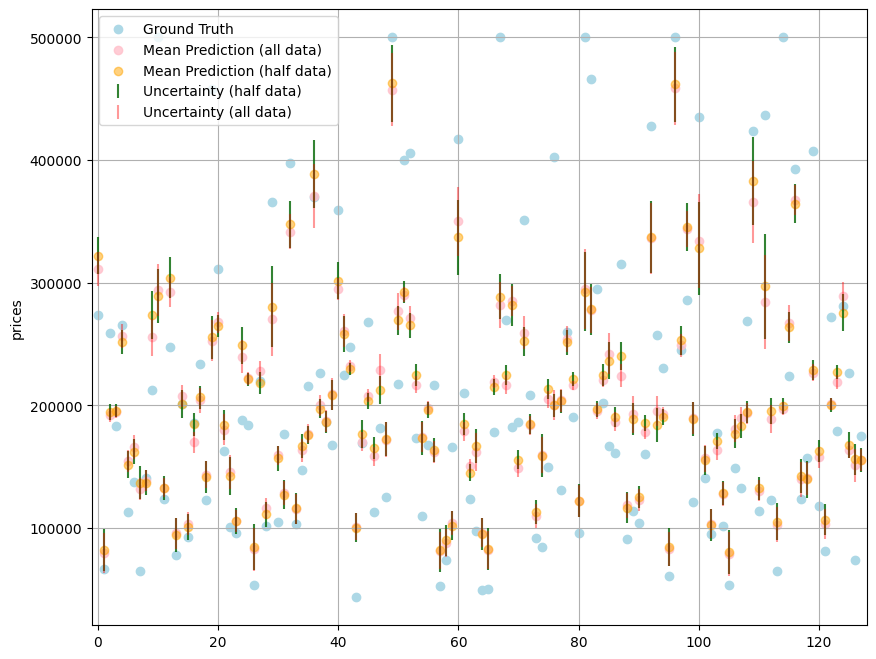

In [28]:
plt.figure(figsize=(10, 8))
plt.xlim(-1,PLOT)
plt.scatter(x_axis, y_plot, color='lightblue', label="Ground Truth")
plt.scatter(x_axis, y_mean_predict.flatten(), color='pink', alpha=0.8, label='Mean Prediction (all data)')
# plt.errorbar(x_axis, y_mean_predict.flatten(), yerr=root_mse, fmt='none', ecolor='pink', label="Root MSE (all data)")

plt.scatter(x_axis, y_50_mean_predict.flatten(), color='orange', alpha=0.5, label='Mean Prediction (half data)')
# plt.errorbar(x_axis, y_50_mean_predict.flatten(), yerr=root_mse_50, fmt='none', ecolor='yellow', alpha=0.6, label="Root MSE (half data)")


plt.errorbar(x_axis, y_50_mean_predict.flatten(), yerr=y_50_sd_predict.flatten(), fmt='none', color='darkgreen', alpha=0.8, label="Uncertainty (half data)")
plt.errorbar(x_axis, y_mean_predict.flatten(), yerr=y_var_predict.flatten(), fmt='none', color='red', alpha=0.4, label="Uncertainty (all data)")

plt.ylabel('prices')
plt.legend()
plt.grid(True)  # Enable grid for better visualization
plt.show()

In [584]:
# find the data points with the largest and smallest difference

In [26]:
print(y_test.loc[[PLOT]])

     Median_House_Value
128            500001.0


In [27]:
gbt_explanation_lime = gbt_model.explain_lime(X_test.loc[[PLOT]])

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ trea

 98/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

110/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

106/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 54/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 27/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 66/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

104/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

106/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 48/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

106/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 91/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 99/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

113/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 84/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

115/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 57/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 82/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 84/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

110/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 56/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 77/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

116/157 [=====================>........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

113/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

113/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 878us/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

106/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 84/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 50/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 52/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 54/157 [=========>....................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 52/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 45/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 54/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 50/157 [========>.....................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 53/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

104/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

110/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

104/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

110/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

104/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 54/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 28/157 [====>.........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 54/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

110/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 62/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 80/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

In [28]:
gbt_explanation_50_lime = gbt_model_50.explain_lime(X_test.loc[[PLOT]])

 58/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ trea

 48/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 50/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

110/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 57/157 [=========>....................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 81/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 79/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

114/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

110/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

106/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

106/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

103/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

107/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 57/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 99/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 97/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 57/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 53/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

118/157 [=====================>........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

107/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

106/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

107/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 78/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

107/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

105/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

110/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 68/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 42/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 87/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

100/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 58/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 98/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

114/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 27/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 63/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 53/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 58/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 99/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

107/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

110/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 97/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 898us/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 61/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 54/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 99/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 50/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 889us/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

112/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

107/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

101/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

114/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

111/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

114/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 76/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

110/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

113/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

113/157 [====================>.........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

103/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

109/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

107/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

108/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 929us/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

In [39]:
gbt_explanation_shap=gbt_model.explain_shap(X_test.loc[[PLOT]])

In [30]:
gbt_explanation_50_shap=gbt_model_50.explain_shap(X_test.loc[[PLOT]])

In [31]:
#check
for i, explanation in enumerate(gbt_explanation_lime):
    print(f"Explanation {i + 1}:")
    print("As List of Tuples (feature_id, weight):")
    for feature_id, weight in explanation.as_list():
        print(f"Feature {feature_id}: {weight}")

    print("\n")

Explanation 1:
As List of Tuples (feature_id, weight):
Feature Median_Income > 0.46: 145910.34675950705
Feature Distance_to_coast > 0.19: -74310.82917209736
Feature Latitude > 0.97: -29885.98233182173
Feature Median_Age > 0.66: 9660.004822866968
Feature Distance_to_LA > 1.04: -9127.3491750448
Feature Tot_Bedrooms > 0.26: 7821.422781684859
Feature Population > 0.27: -7548.776708433548
Feature Households > 0.28: 5285.8921707093095
Feature Tot_Rooms > 0.24: 4682.600240575412
Feature Longitude <= -1.11: 3716.9702079156027
Feature Distance_to_SanDiego > 1.06: 3383.229347103863
Feature Distance_to_SanFrancisco > 0.79: -3111.2577266168823
Feature Distance_to_SanJose > 0.77: -1270.1937648959824


Explanation 2:
As List of Tuples (feature_id, weight):
Feature Median_Income > 0.46: 146860.4006619452
Feature Distance_to_coast > 0.19: -75846.6379685694
Feature Latitude > 0.97: -28890.13723567268
Feature Tot_Rooms > 0.24: 12603.757810105955
Feature Tot_Bedrooms > 0.26: 12061.26951838323
Feature Pop

In [38]:
print(gbt_explanation_shap[0])

.values =
array([[4890.2621875,    0.       ,    0.       ,    0.       ,
           0.       ,    0.       ,    0.       ,    0.       ,
           0.       ,    0.       ,    0.       ,    0.       ,
           0.       ]])

.base_values =
array([[282879.9253125]])

.data =
array([[ 4.20420000e+00,  5.20000000e+01,  3.21900000e+03,
         9.69000000e+02,  1.15200000e+03,  8.30000000e+02,
         3.77900000e+01, -1.22430000e+02,  1.63462373e+03,
         5.60978041e+05,  7.39479269e+05,  6.92418140e+04,
         1.78587352e+03]])


In [33]:
feature_weights = defaultdict(list)

for explanation in gbt_explanation_lime:
    for feature, weight in explanation.as_list():
        feature_weights[feature].append(weight)

feature_stats = {}
for feature, weights in feature_weights.items():
    mean_weight = np.mean(weights)
    std_weight = np.std(weights)
    feature_stats[feature] = {'mean': mean_weight, 'std': std_weight}

print(feature_stats)

{'Median_Income > 0.46': {'mean': 143621.21167620723, 'std': 11838.17172888039}, 'Distance_to_coast > 0.19': {'mean': -66877.40977299257, 'std': 7047.836437324331}, 'Latitude > 0.97': {'mean': -21720.77289528069, 'std': 7955.348512048343}, 'Median_Age > 0.66': {'mean': 8496.737546104687, 'std': 2258.318184811879}, 'Distance_to_LA > 1.04': {'mean': -10508.1758600606, 'std': 4463.750176314232}, 'Tot_Bedrooms > 0.26': {'mean': 7015.520082322847, 'std': 5376.4068786924345}, 'Population > 0.27': {'mean': -5626.532002415066, 'std': 5796.283110163555}, 'Households > 0.28': {'mean': 1367.127573586223, 'std': 2557.341712888279}, 'Tot_Rooms > 0.24': {'mean': 4143.942748800503, 'std': 4782.235742484086}, 'Longitude <= -1.11': {'mean': 4537.302482837285, 'std': 3925.58817678463}, 'Distance_to_SanDiego > 1.06': {'mean': 2479.896805995725, 'std': 1768.7076909629177}, 'Distance_to_SanFrancisco > 0.79': {'mean': -3225.8740477060355, 'std': 2065.2794594717375}, 'Distance_to_SanJose > 0.77': {'mean': -6

In [34]:
feature_order = X_test.columns.tolist()
def sort_key(x):
    for op in [' >= ', ' <= ', ' > ', ' < ', ' = ']:
        if op in x:
            return feature_order.index(x.split(op)[0])
        
sorted_keys = sorted(feature_stats.keys(), key=sort_key)
sorted_feature_stats = {key: feature_stats[key] for key in sorted_keys}

print(sorted_feature_stats)

{'Median_Income > 0.46': {'mean': 143621.21167620723, 'std': 11838.17172888039}, 'Median_Age > 0.66': {'mean': 8496.737546104687, 'std': 2258.318184811879}, 'Tot_Rooms > 0.24': {'mean': 4143.942748800503, 'std': 4782.235742484086}, 'Tot_Bedrooms > 0.26': {'mean': 7015.520082322847, 'std': 5376.4068786924345}, 'Population > 0.27': {'mean': -5626.532002415066, 'std': 5796.283110163555}, 'Households > 0.28': {'mean': 1367.127573586223, 'std': 2557.341712888279}, 'Latitude > 0.97': {'mean': -21720.77289528069, 'std': 7955.348512048343}, 'Longitude <= -1.11': {'mean': 4537.302482837285, 'std': 3925.58817678463}, 'Distance_to_coast > 0.19': {'mean': -66877.40977299257, 'std': 7047.836437324331}, 'Distance_to_LA > 1.04': {'mean': -10508.1758600606, 'std': 4463.750176314232}, 'Distance_to_SanDiego > 1.06': {'mean': 2479.896805995725, 'std': 1768.7076909629177}, 'Distance_to_SanJose > 0.77': {'mean': -6568.5503592935, 'std': 3112.6201151829396}, 'Distance_to_SanFrancisco > 0.79': {'mean': -3225

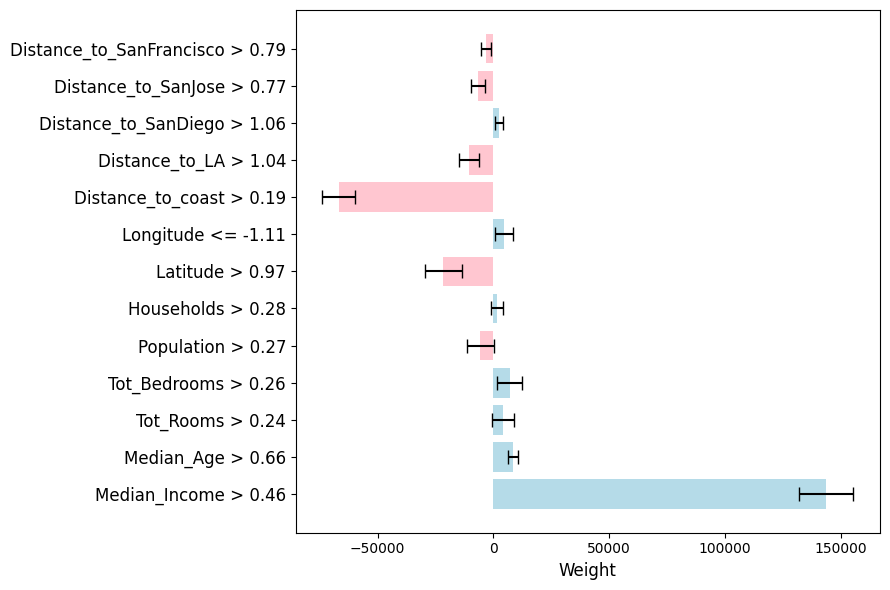

weights [143621.21167620723, 8496.737546104687, 4143.942748800503, 7015.520082322847, -5626.532002415066, 1367.127573586223, -21720.77289528069, 4537.302482837285, -66877.40977299257, -10508.1758600606, 2479.896805995725, -6568.5503592935, -3225.8740477060355] sd [11838.17172888039, 2258.318184811879, 4782.235742484086, 5376.4068786924345, 5796.283110163555, 2557.341712888279, 7955.348512048343, 3925.58817678463, 7047.836437324331, 4463.750176314232, 1768.7076909629177, 3112.6201151829396, 2065.2794594717375]


In [35]:
features = list(sorted_feature_stats.keys())
mean_weights = [sorted_feature_stats[feature]['mean'] for feature in features]
std_weights = [sorted_feature_stats[feature]['std'] for feature in features]

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_weights]

feature_ids = range(len(mean_weights))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_weights, xerr=std_weights, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, features, fontsize=12)
plt.xlabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

print("weights", mean_weights, "sd", std_weights)

In [36]:
stacked_shap_values = np.vstack([gbt_explanation_shap[i].values for i in range(len(gbt_explanation_shap))])
mean_shap_values = np.mean(stacked_shap_values, axis=0)
sd_shap_values = np.std(stacked_shap_values, axis=0)
shap_features = X_test.loc[[PLOT]].columns.tolist()

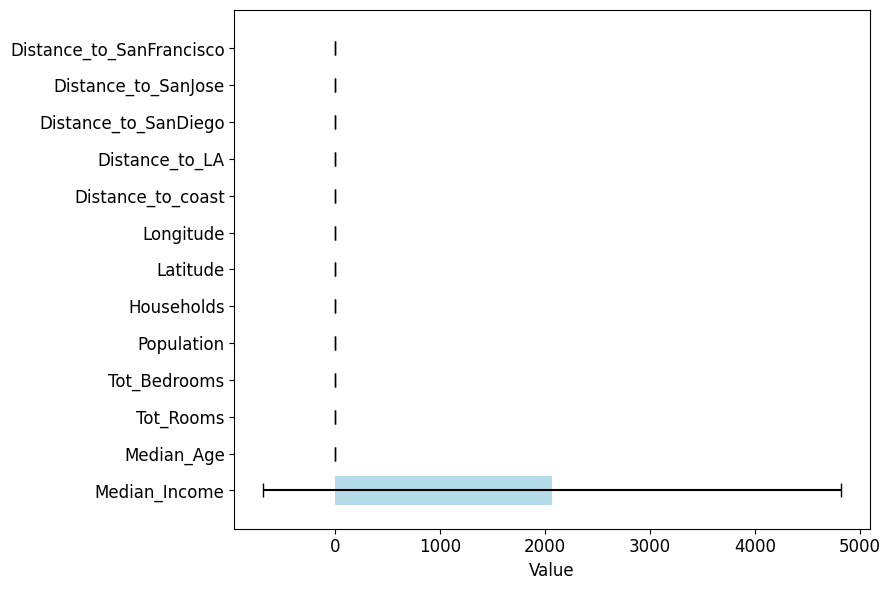

In [37]:

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_shap_values]

feature_ids = range(len(mean_shap_values))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_shap_values, xerr=sd_shap_values, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, shap_features, fontsize=12)
plt.xlabel("Value", fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

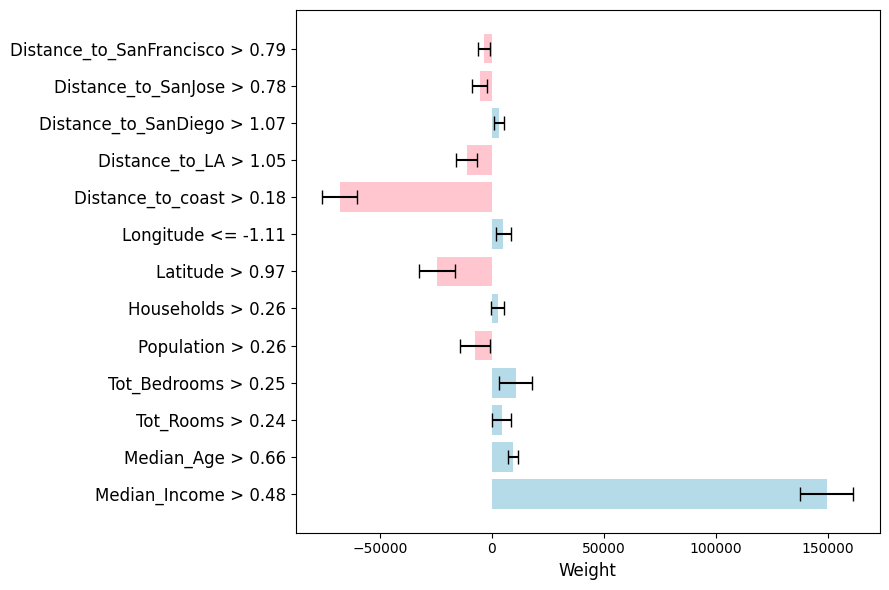

weights [149645.41419071867, 9507.397353351498, 4336.245228819478, 10692.767643455005, -7425.562844953291, 2586.4021336273718, -24444.617140155977, 5117.35842543919, -67901.16630838069, -11293.2727348346, 3296.9632473322795, -5426.0500601297845, -3540.5224867950556] sd [11867.330296044582, 2179.4332055278555, 4211.436006001298, 7337.9485364732955, 6620.218889006108, 3049.4624424433227, 8138.366562139257, 3443.6907401874987, 7801.826658930638, 4481.178766739339, 2310.766303783451, 3214.877344021525, 2592.1470229728375]


In [41]:
feature_weights_50 = defaultdict(list)

for explanation in gbt_explanation_50_lime:
    for feature, weight in explanation.as_list():
        feature_weights_50[feature].append(weight)

feature_stats_50 = {}
for feature, weights in feature_weights_50.items():
    mean_weight_50 = np.mean(weights)
    std_weight_50 = np.std(weights)
    feature_stats_50[feature] = {'mean': mean_weight_50, 'std': std_weight_50}

sorted_keys_50 = sorted(feature_stats_50.keys(), key=sort_key)
sorted_feature_stats_50 = {key: feature_stats_50[key] for key in sorted_keys_50}

features = list(sorted_feature_stats_50.keys())
mean_weights = [sorted_feature_stats_50[feature]['mean'] for feature in features]
std_weights = [sorted_feature_stats_50[feature]['std'] for feature in features]

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_weights]

feature_ids = range(len(mean_weights))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_weights, xerr=std_weights, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, features, fontsize=12)
plt.xlabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

print("weights", mean_weights, "sd", std_weights)

In [45]:
weights_try=mean_weights
weights_try[0]=-11644.5538
weights_try[4]=-7237.4925
weights_try[3]=-4562.9556
weights_try[2]=-3960.2858
weights_try[1]=-1903.7930
weights_try[5]=-1373.4202
weights_try[10]=1015.1179
weights_try[6]=-887.2533
weights_try[12]= 729.0032
weights_try[11]=808.1198

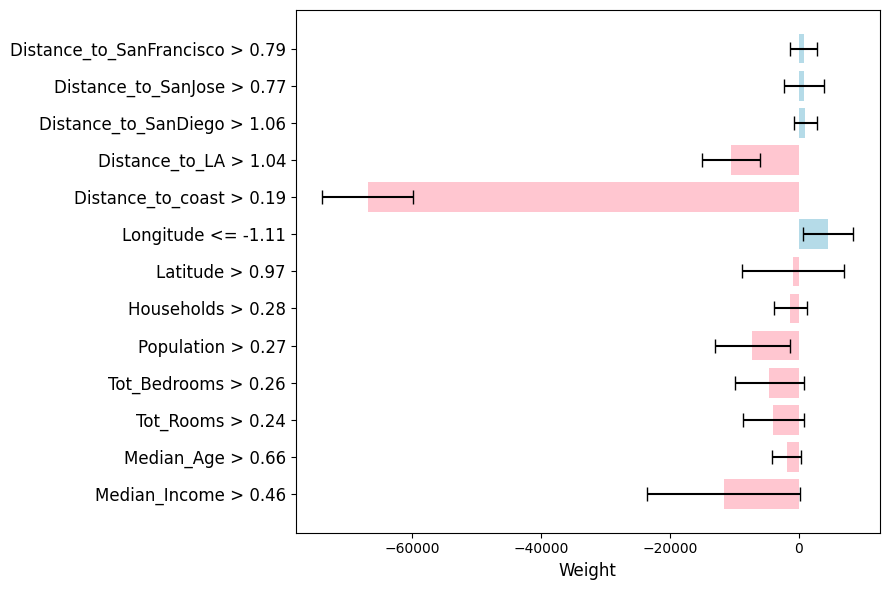

weights [143621.21167620723, 8496.737546104687, 4143.942748800503, 7015.520082322847, -5626.532002415066, 1367.127573586223, -21720.77289528069, 4537.302482837285, -66877.40977299257, -10508.1758600606, 2479.896805995725, -6568.5503592935, -3225.8740477060355] sd [11838.17172888039, 2258.318184811879, 4782.235742484086, 5376.4068786924345, 5796.283110163555, 2557.341712888279, 7955.348512048343, 3925.58817678463, 7047.836437324331, 4463.750176314232, 1768.7076909629177, 3112.6201151829396, 2065.2794594717375]


In [46]:
features = list(sorted_feature_stats.keys())
mean_weights = [sorted_feature_stats[feature]['mean'] for feature in features]
std_weights = [sorted_feature_stats[feature]['std'] for feature in features]

colors = ['lightblue' if weight > 0 else 'pink' for weight in weights_try]

feature_ids = range(len(weights_try))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, weights_try, xerr=std_weights, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, features, fontsize=12)
plt.xlabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

print("weights", mean_weights, "sd", std_weights)

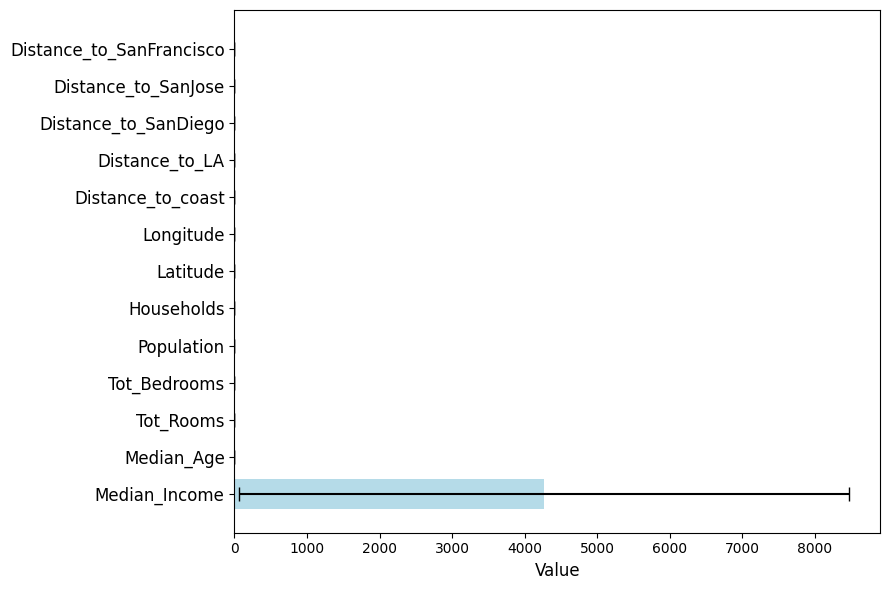

In [42]:

stacked_shap_values_50 = np.vstack([gbt_explanation_50_shap[i].values for i in range(len(gbt_explanation_50_shap))])
mean_shap_values_50 = np.mean(stacked_shap_values_50, axis=0)
sd_shap_values_50 = np.std(stacked_shap_values_50, axis=0)
shap_features = X_test.loc[[10]].columns.tolist()

feature_ids = range(len(mean_shap_values_50))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_shap_values_50, xerr=sd_shap_values_50, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, shap_features, fontsize=12)
plt.xlabel("Value", fontsize=12)
plt.tight_layout()
plt.show()